In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
from pandas import DataFrame

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
torch.__version__

'1.3.0'

In [5]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [21]:
device = torch.device('cuda:9')

In [7]:
from utils.data_loaders import get_loaders, get_shape

In [8]:
dataset_name = 'mnist'

batch_size = 1000
train_size = 1000

train_loader, test_loader, test_loader_det = get_loaders(dataset_name, batch_size, train_size)

In [9]:
input_shape, num_classes = get_shape(dataset_name)

In [115]:
def defaultdict_to_dict(def_a: defaultdict):
    a = dict()
    for k, v in def_a.items():
        if isinstance(v, defaultdict):
            v = defaultdict_to_dict(v)
        a[k] = v
    return a

In [11]:
from collections import defaultdict


final_result_dict_constructor = lambda: defaultdict(
    lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(
        lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(int)))))))

final_train_losses = final_result_dict_constructor()
final_test_losses = final_result_dict_constructor()

final_train_accs = final_result_dict_constructor()
final_test_accs = final_result_dict_constructor()

In [112]:
import pickle

results_dir = 'results/adam/final/'

with open(results_dir+'final_train_losses.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(final_train_losses), f)
with open(results_dir+'final_test_losses.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(final_test_losses), f)
with open(results_dir+'final_train_accs.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(final_train_accs), f)
with open(results_dir+'final_test_accs.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(final_test_accs), f)
    

In [42]:
num_epochs = 50
#max_test_batch_count = 10
#print_every = 10
eval_every = 5
num_seeds = 10

num_hidden = 1
bias = False
base_lr = 1e-3

base_widths = [8192]
scaling_modes = ['default', 'preserve_initial_logit_std', 'preserve_logit_mean', 'invariant_new']
log_width_factors = [-4, -2, 0]
log_lr_factors = list(range(-3, 4))

for bias in biases[:1]:
    for base_width in base_widths:
        for scaling_mode in scaling_modes[-1:]:
            for log_width_factor in log_width_factors:
                for log_lr_factor in log_lr_factors:
                    for seed in range(num_seeds):
                        print('bias = {}'.format(bias))
                        print('base width = {}'.format(base_width))
                        print('scaling mode: {}'.format(scaling_mode))
                        print('log width factor = {}'.format(log_width_factor))
                        print('log lr factor = {}'.format(log_lr_factor))
                        print('seed = {}'.format(seed))

                        torch.manual_seed(seed)
                        np.random.seed(seed)

                        if log_width_factor >= 0:
                            width = base_width * (2 ** log_width_factor)
                        else:
                            width = base_width // (2 ** (-log_width_factor))

                        mod_base_lr = base_lr * (2 ** log_lr_factor)

                        model = FCNet(input_shape, num_classes, width=width, num_hidden=num_hidden, bias=bias).to(device)

                        for epoch in range(num_epochs):
                            model.train()
                            train_loss, train_acc = perform_epoch(
                                model, train_loader, optimizers=optimizers, batches_per_updates=batches_per_updates)

                            if (epoch+1) % eval_every == 0:
                                final_train_losses[bias][base_width][scaling_mode][log_width_factor][log_lr_factor][seed][epoch] = train_loss
                                final_train_accs[bias][base_width][scaling_mode][log_width_factor][log_lr_factor][seed][epoch] = train_acc

                                model.eval()
                                test_loss, test_acc = perform_epoch(model, test_loader)
                                final_test_losses[bias][base_width][scaling_mode][log_width_factor][log_lr_factor][seed][epoch] = test_loss
                                final_test_accs[bias][base_width][scaling_mode][log_width_factor][log_lr_factor][seed][epoch] = test_acc

                        print('train loss = {:.4f}, train acc = {:.2f}'.format(train_loss, train_acc*100))
                        print('test loss = {:.4f}, test acc = {:.2f}'.format(test_loss, test_acc*100))            
                        print()


bias = False
base width = 8192
scaling mode: invariant_new
log width factor = -4
log lr factor = -3
seed = 0
train loss = 0.1484, train acc = 97.40
test loss = 0.3645, test acc = 89.02

bias = False
base width = 8192
scaling mode: invariant_new
log width factor = -4
log lr factor = -3
seed = 1
train loss = 0.1426, train acc = 97.30
test loss = 0.3679, test acc = 88.63

bias = False
base width = 8192
scaling mode: invariant_new
log width factor = -4
log lr factor = -3
seed = 2
train loss = 0.1434, train acc = 97.20
test loss = 0.3610, test acc = 88.96

bias = False
base width = 8192
scaling mode: invariant_new
log width factor = -4
log lr factor = -3
seed = 3
train loss = 0.1329, train acc = 97.80
test loss = 0.3727, test acc = 88.71

bias = False
base width = 8192
scaling mode: invariant_new
log width factor = -4
log lr factor = -3
seed = 4
train loss = 0.1441, train acc = 97.00
test loss = 0.3712, test acc = 88.51

bias = False
base width = 8192
scaling mode: invariant_new
log width f

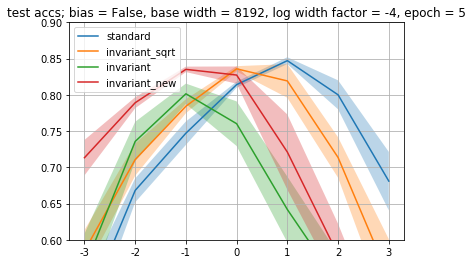

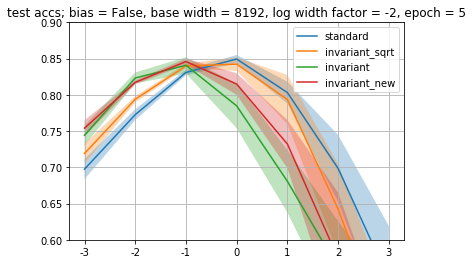

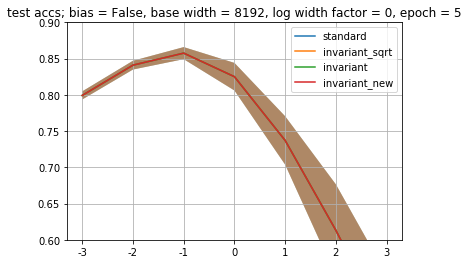

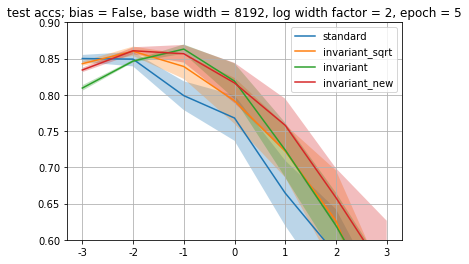

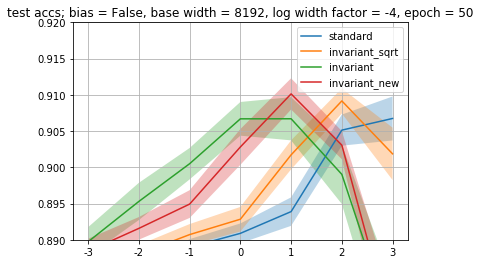

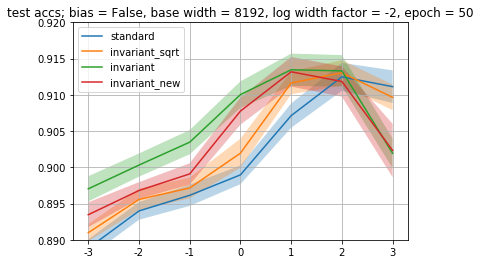

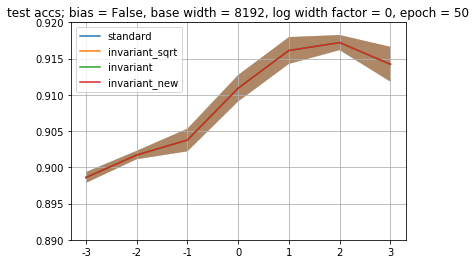

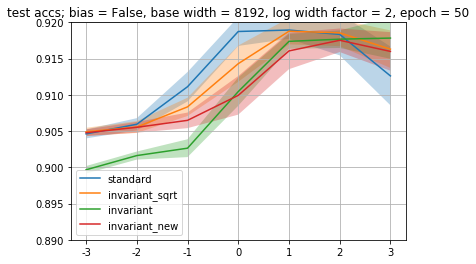

In [46]:
for bias in biases[:-1]:
    for base_width in base_widths:
        for epoch in [5, 50]:
            for log_width_factor in log_width_factors:
                for scaling_mode in scaling_modes:
                    data = [[
                        final_test_accs[bias][base_width][scaling_mode][log_width_factor][log_lr_factor][seed][epoch-1]
                        for log_lr_factor in log_lr_factors
                    ] for seed in range(num_seeds)]
                    data = np.array(data)
                    data_mean = data.mean(axis=0)
                    data_std = data.std(axis=0)
                    plt.plot(np.arange(len(log_lr_factors)), data_mean)
                    plt.fill_between(
                        np.arange(len(log_lr_factors)),
                        data_mean - data_std,
                        data_mean + data_std,
                        alpha=0.3
                    )

                plt.grid(True)
                plt.legend(scaling_modes)
                plt.xticks(np.arange(len(log_lr_factors)), log_lr_factors)
                plt.title('test accs; bias = {}, base width = {}, log width factor = {}, epoch = {}'.format(bias, base_width, log_width_factor, epoch))
                if epoch == 5:
                    plt.ylim((0.6,0.9))
                elif epoch == 50:
                    plt.ylim((0.89,0.92))
                plt.show()

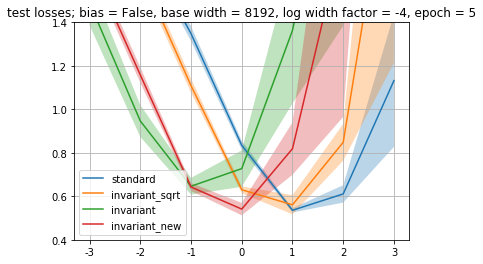

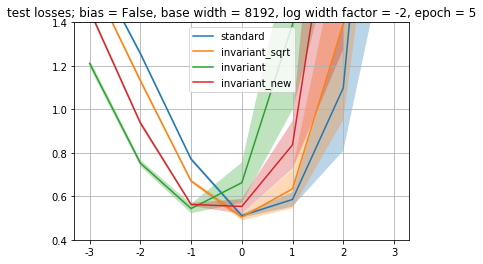

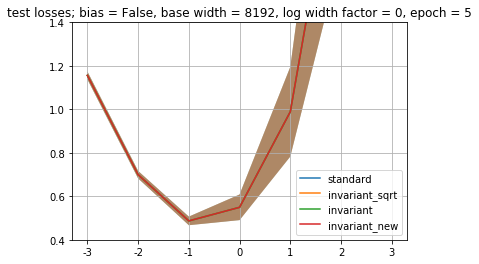

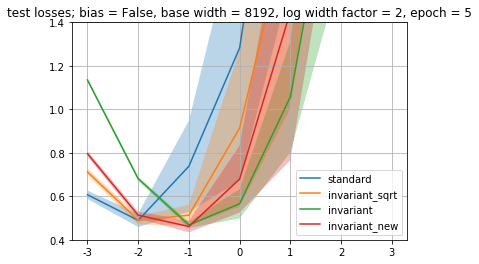

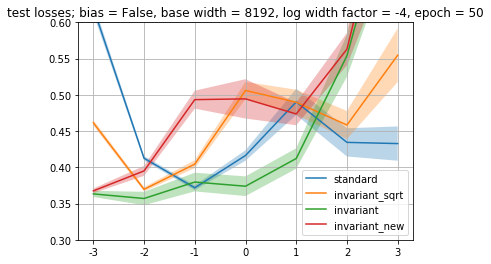

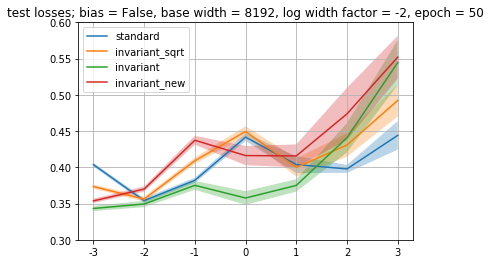

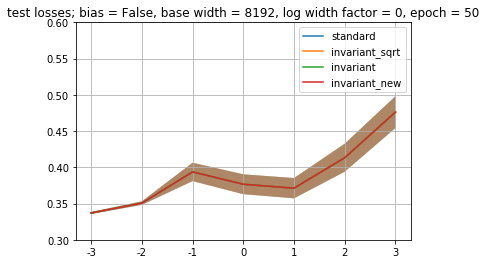

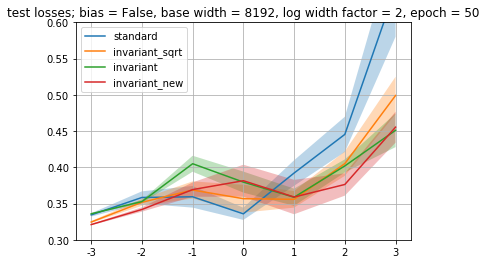

In [51]:
for bias in biases[:-1]:
    for base_width in base_widths:
        for epoch in [5, 50]:
            for log_width_factor in log_width_factors:
                for scaling_mode in scaling_modes:
                    data = [[
                        final_test_losses[bias][base_width][scaling_mode][log_width_factor][log_lr_factor][seed][epoch-1]
                        for log_lr_factor in log_lr_factors
                    ] for seed in range(num_seeds)]
                    data = np.array(data)
                    data_mean = data.mean(axis=0)
                    data_std = data.std(axis=0)
                    plt.plot(np.arange(len(log_lr_factors)), data_mean)
                    plt.fill_between(
                        np.arange(len(log_lr_factors)),
                        data_mean - data_std,
                        data_mean + data_std,
                        alpha=0.3
                    )

                plt.grid(True)
                plt.legend(scaling_modes)
                plt.xticks(np.arange(len(log_lr_factors)), log_lr_factors)
                plt.title('test losses; bias = {}, base width = {}, log width factor = {}, epoch = {}'.format(bias, base_width, log_width_factor, epoch))
                if epoch == 5:
                    plt.ylim((0.4,1.4))
                elif epoch == 50:
                    plt.ylim((0.3,0.6))
                plt.show()

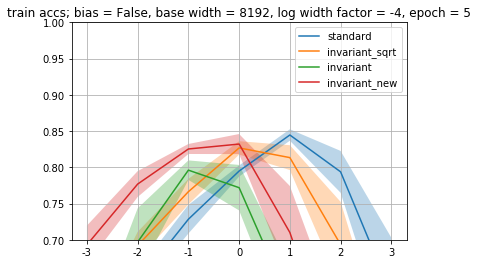

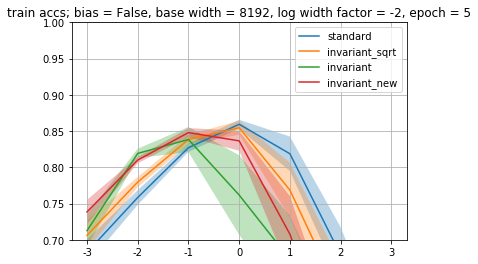

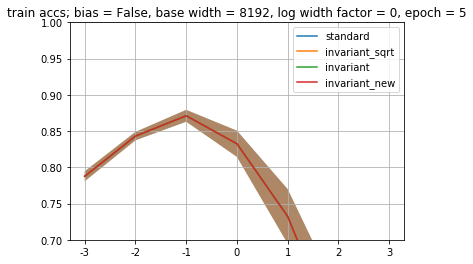

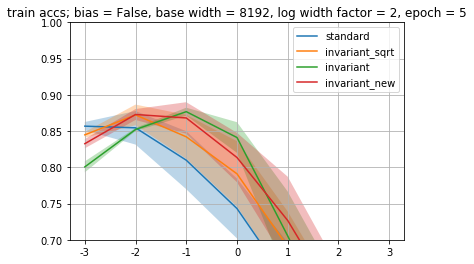

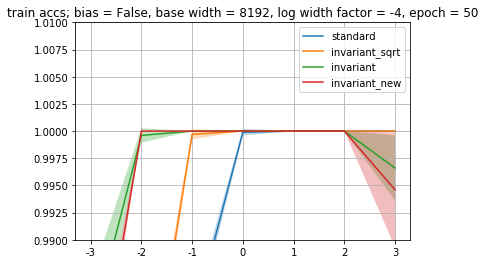

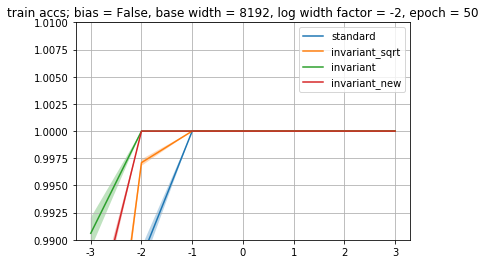

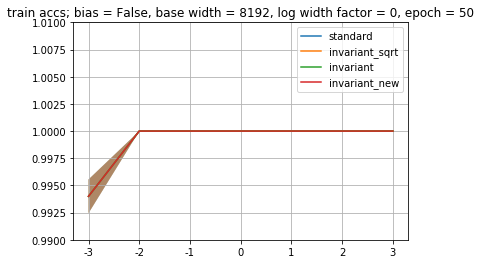

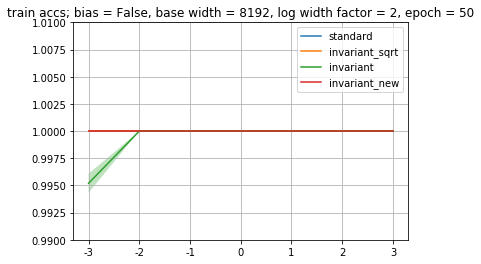

In [54]:
for bias in biases[:-1]:
    for base_width in base_widths:
        for epoch in [5, 50]:
            for log_width_factor in log_width_factors:
                for scaling_mode in scaling_modes:
                    data = [[
                        final_train_accs[bias][base_width][scaling_mode][log_width_factor][log_lr_factor][seed][epoch-1]
                        for log_lr_factor in log_lr_factors
                    ] for seed in range(num_seeds)]
                    data = np.array(data)
                    data_mean = data.mean(axis=0)
                    data_std = data.std(axis=0)
                    plt.plot(np.arange(len(log_lr_factors)), data_mean)
                    plt.fill_between(
                        np.arange(len(log_lr_factors)),
                        data_mean - data_std,
                        data_mean + data_std,
                        alpha=0.3
                    )

                plt.grid(True)
                plt.legend(scaling_modes)
                plt.xticks(np.arange(len(log_lr_factors)), log_lr_factors)
                plt.title('train accs; bias = {}, base width = {}, log width factor = {}, epoch = {}'.format(bias, base_width, log_width_factor, epoch))
                if epoch == 5:
                    plt.ylim((0.7,1.0))
                elif epoch == 50:
                    plt.ylim((0.99,1.01))
                plt.show()

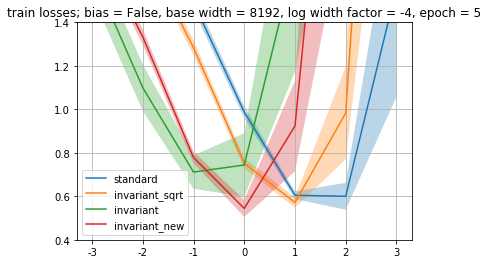

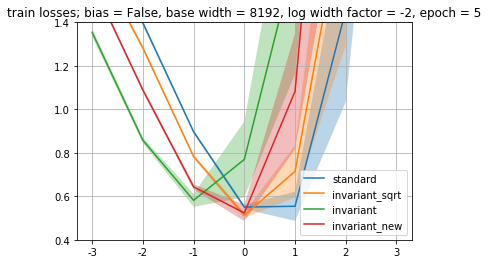

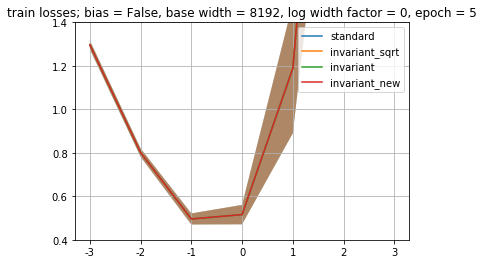

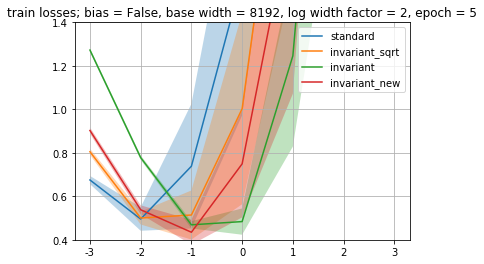

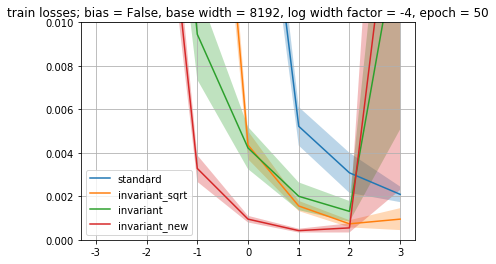

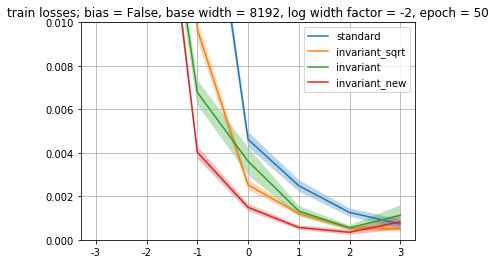

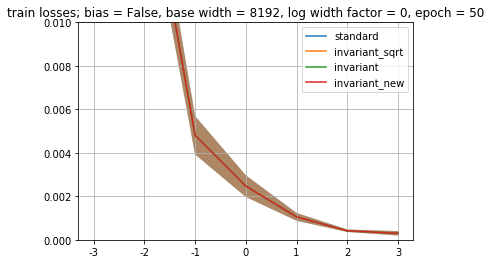

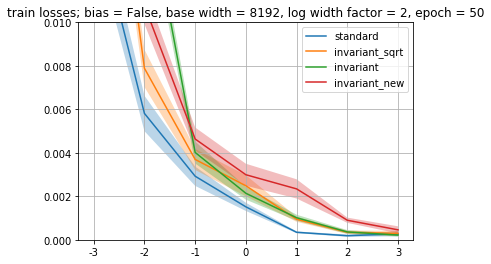

In [59]:
for bias in biases[:-1]:
    for base_width in base_widths:
        for epoch in [5, 50]:
            for log_width_factor in log_width_factors:
                for scaling_mode in scaling_modes:
                    data = [[
                        final_train_losses[bias][base_width][scaling_mode][log_width_factor][log_lr_factor][seed][epoch-1]
                        for log_lr_factor in log_lr_factors
                    ] for seed in range(num_seeds)]
                    data = np.array(data)
                    data_mean = data.mean(axis=0)
                    data_std = data.std(axis=0)
                    plt.plot(np.arange(len(log_lr_factors)), data_mean)
                    plt.fill_between(
                        np.arange(len(log_lr_factors)),
                        data_mean - data_std,
                        data_mean + data_std,
                        alpha=0.3
                    )

                plt.grid(True)
                plt.legend(scaling_modes)
                plt.xticks(np.arange(len(log_lr_factors)), log_lr_factors)
                plt.title('train losses; bias = {}, base width = {}, log width factor = {}, epoch = {}'.format(bias, base_width, log_width_factor, epoch))
                if epoch == 5:
                    plt.ylim((0.4,1.4))
                elif epoch == 50:
                    plt.ylim((0.,0.01))
                plt.show()

| epoch | train loss  | train acc   | test loss   | test acc         |
|-------|-------------|-------------|-------------|------------------|
|   5   | inv/inv_new | inv/inv_new | inv/inv_new | inv_new/inv      |
|   50  | inv_new/inv | inv/inv_new | inv/inv_new | inv_sqrt/inv_new |

# Tracking statistics:

In [53]:
from collections import defaultdict

class NestedDefaultDictConstructor():
    def __init__(self, base_type, depth):
        super(NestedDefaultDictConstructor, self).__init__()
        self.depth = depth
        self.base_type = base_type
        
    def _nest_defaultdicts(self, def_dict):
        return defaultdict(lambda: def_dict)
        
    def __call__(self):
        def_dict = self.base_type
        for _ in range(self.depth):
            def_dict = self._nest_defaultdicts(def_dict)
        return def_dict

In [84]:
#defaultdict_constructor = NestedDefaultDictConstructor(float, 7)
defaultdict_constructor = lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(float)))))))

train_losses = defaultdict_constructor()
test_losses = defaultdict_constructor()

train_accs = defaultdict_constructor()
test_accs = defaultdict_constructor()

In [85]:
#defaultdict_constructor = NestedDefaultDictConstructor(float, 6)
defaultdict_constructor = lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(float))))))

class_mean_data_mean_mean_logit = defaultdict_constructor()
class_mean_data_mean_std_logit = defaultdict_constructor()

In [113]:
import pickle

results_dir = 'results/adam/epoch_wise/'

with open(results_dir+'train_losses.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(train_losses), f)
with open(results_dir+'test_losses.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(test_losses), f)
with open(results_dir+'train_accs.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(train_accs), f)
with open(results_dir+'test_accs.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(test_accs), f)

with open(results_dir+'class_mean_data_mean_mean_logit.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(class_mean_data_mean_mean_logit), f)
with open(results_dir+'class_mean_data_mean_std_logit.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(class_mean_data_mean_std_logit), f)
    

In [86]:
num_epochs = 50
eval_every = 1
num_seeds = 3

num_hidden = 1
bias = False
base_lr = 0.01
optimizer_class = optim.SGD

base_widths = [8192]
adaptivity_modes = ['none', 'adapt_mean', 'adapt_std', 'adapt_mean_std_av']
scaling_modes = ['default', 'preserve_initial_logit_std', 'preserve_logit_mean']
log_width_factors = [-2, 0]
log_lr_factors = [0]

In [22]:
%load_ext autoreload
%autoreload 2

In [24]:
from utils.init_model import scale_hyperparams
from utils.models import FCNet

from utils.train_and_eval import perform_epoch

In [14]:
from itertools import chain

In [ ]:
for base_width in base_widths:
    for adaptivity_mode in adaptivity_modes:
        for scaling_mode in scaling_modes:
            if adaptivity_mode != 'none' and scaling_mode != 'preserve_initial_logit_std':
                continue
            for log_width_factor in log_width_factors[::-1]:
                if scaling_mode != 'default' and log_width_factor == 0:
                    continue
                for log_lr_factor in log_lr_factors:
                    print('base width = {}'.format(base_width))
                    print('adaptivity mode = {}'.format(adaptivity_mode))
                    print('scaling mode: {}'.format(scaling_mode))
                    print('log width factor = {}'.format(log_width_factor))
                    print('log lr factor = {}'.format(log_lr_factor))

                    if log_width_factor >= 0:
                        width = base_width * (2 ** log_width_factor)
                    else:
                        width = base_width // (2 ** (-log_width_factor))

                    mod_base_lr = base_lr * (2 ** log_lr_factor)

                    models = []
                    states = []
                    optimizers = []
                    
                    for seed in range(num_seeds):
                        torch.manual_seed(seed)
                        #np.random.seed(seed)

                        model = FCNet(input_shape, num_classes, width=width, num_hidden=num_hidden, bias=bias).to(device)
                        models.append(model)
                        
                        optimizer = optimizer_class(
                            [
                                {'params': model.input_layer.parameters()},
                                {'params': model.hidden_layers.parameters()},
                                {'params': model.output_layer.parameters()}
                            ], lr=mod_base_lr
                        )
                        optimizers.append(optimizer)
                        
                        scale_hyperparams(
                            model.input_layer, model.hidden_layers, model.output_layer, 
                            optimizer=optimizer, width_factor=2**log_width_factor, scaling_mode=scaling_mode
                        )
                            
                        states.append(torch.get_rng_state())

                    for epoch in range(num_epochs):
                        if epoch % eval_every == 0:
                            logits = []

                            for model, state, seed in zip(models, states, range(num_seeds)):
                                torch.set_rng_state(state)
                                
                                model.eval()
                                logits.append([])
                                with torch.no_grad():
                                    for X, _ in test_loader_det:
                                        X = X.to(device)
                                        logits[-1].append(model(X))
                                logits[-1] = torch.cat(logits[-1])

                            logits = torch.stack(logits)
                            std_logits, mean_logits = torch.std_mean(logits, dim=0)
                            mean_std_logit, mean_mean_logit = std_logits.mean().item(), mean_logits.mean().item()
                            #print(mean_std_logit, mean_mean_logit)

                            class_mean_data_mean_mean_logit[base_width][adaptivity_mode][scaling_mode][log_width_factor][log_lr_factor][epoch] = mean_mean_logit
                            class_mean_data_mean_std_logit[base_width][adaptivity_mode][scaling_mode][log_width_factor][log_lr_factor][epoch] = mean_std_logit

                            mean_mean_logit_ref = class_mean_data_mean_mean_logit[base_width]['none']['default'][0][log_lr_factor][epoch]
                            mean_std_logit_ref = class_mean_data_mean_std_logit[base_width]['none']['default'][0][log_lr_factor][epoch]
                            #print(mean_std_logit_ref, mean_mean_logit_ref)

                            correction_factor_from_mean_logits = mean_mean_logit_ref / mean_mean_logit
                            correction_factor_from_std_logits = mean_std_logit_ref / mean_std_logit

                            print('epoch {}'.format(epoch+1))
                            print('correction factor from mean logits = {:.2f}'.format(correction_factor_from_mean_logits))
                            print('correction factor from std logits = {:.2f}'.format(correction_factor_from_std_logits))
                            print()

                            if adaptivity_mode == 'none':
                                correction_factor = 1
                            elif adaptivity_mode == 'adapt_mean':
                                correction_factor = correction_factor_from_mean_logits
                            elif adaptivity_mode == 'adapt_std':
                                correction_factor = correction_factor_from_std_logits
                            elif adaptivity_mode == 'adapt_mean_std_av':
                                correction_factor = math.sqrt(correction_factor_from_mean_logits * correction_factor_from_std_logits)
                            else:
                                raise ValueError

                            for model, optimizer in zip(models, optimizers):
                                for layer in chain(model.hidden_layers, [model.output_layer]):
                                    if hasattr(layer, 'weight'):
                                        layer.weight.data = layer.weight.data * correction_factor
                                    if hasattr(layer, 'bias'):
                                        if layer.bias is not None:
                                            raise NotImplementedError
                                for param_group in optimizer.param_groups[1:]:
                                    param_group['lr'] *= correction_factor
                            
                        for model, state, seed, optimizer in zip(models, states, range(num_seeds), optimizers):
                            torch.set_rng_state(state)
                            
                            model.train()
                            train_loss, train_acc = perform_epoch(model, train_loader, optimizer=optimizer, device=device)

                            if (epoch+1) % eval_every == 0:
                                train_losses[base_width][adaptivity_mode][scaling_mode][log_width_factor][log_lr_factor][seed][epoch] = train_loss
                                train_accs[base_width][adaptivity_mode][scaling_mode][log_width_factor][log_lr_factor][seed][epoch] = train_acc

                                model.eval()
                                test_loss, test_acc = perform_epoch(model, test_loader, device=device)
                                test_losses[base_width][adaptivity_mode][scaling_mode][log_width_factor][log_lr_factor][seed][epoch] = test_loss
                                test_accs[base_width][adaptivity_mode][scaling_mode][log_width_factor][log_lr_factor][seed][epoch] = test_acc

                            state = torch.get_rng_state()

                            if epoch == num_epochs - 1:
                                print('seed = {}'.format(seed))
                                print('train loss = {:.4f}, train acc = {:.2f}'.format(train_loss, train_acc*100))
                                print('test loss = {:.4f}, test acc = {:.2f}'.format(test_loss, test_acc*100))            
                                print()
                            

base width = 8192
adaptivity mode = none
scaling mode: default
log width factor = 0
log lr factor = 0
epoch 1
correction factor from mean logits = 1.00
correction factor from std logits = 1.00

epoch 2
correction factor from mean logits = 1.00
correction factor from std logits = 1.00

epoch 3
correction factor from mean logits = 1.00
correction factor from std logits = 1.00

epoch 4
correction factor from mean logits = 1.00
correction factor from std logits = 1.00

epoch 5
correction factor from mean logits = 1.00
correction factor from std logits = 1.00

epoch 6
correction factor from mean logits = 1.00
correction factor from std logits = 1.00

epoch 7
correction factor from mean logits = 1.00
correction factor from std logits = 1.00

epoch 8
correction factor from mean logits = 1.00
correction factor from std logits = 1.00

epoch 9
correction factor from mean logits = 1.00
correction factor from std logits = 1.00

epoch 10
correction factor from mean logits = 1.00
correction factor f

In [ ]:
for base_width in base_widths:
    for log_lr_factor in log_lr_factors:
        for log_width_factor in log_width_factors[:-1]:

            data = [[
                test_losses[base_width]['none']['default'][0][log_lr_factor][seed][epoch]
                for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
            ] for seed in range(num_seeds)]
            data = np.array(data)
            data_mean = data.mean(axis=0)
            data_std = data.std(axis=0)
            plt.plot(data_mean)

            for scaling_mode in scaling_modes:
                data = [[
                    test_losses[base_width]['none'][scaling_mode][log_width_factor][log_lr_factor][seed][epoch] 
                    for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                ] for seed in range(num_seeds)]
                data = np.array(data)
                data_mean = data.mean(axis=0)
                data_std = data.std(axis=0)
                plt.plot(data_mean)

            for adaptivity_mode in adaptivity_modes[1:]:
                data = [[
                    test_losses[base_width][adaptivity_mode]['preserve_initial_logit_std'][log_width_factor][log_lr_factor][seed][epoch] 
                    for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                ] for seed in range(num_seeds)]
                data = np.array(data)
                data_mean = data.mean(axis=0)
                data_std = data.std(axis=0)
                plt.plot(data_mean)

            plt.title('test loss; log width factor = {}'.format(log_width_factor))
            plt.legend(['reference'] + scaling_modes + adaptivity_modes[1:])
            #plt.ylim((0.3,0.5))
            plt.show()

In [ ]:
for base_width in base_widths:
    for log_lr_factor in log_lr_factors:
        for log_width_factor in log_width_factors[:-1]:

            data_ref = [
                class_mean_data_mean_mean_logit[base_width]['none']['default'][0][log_lr_factor][epoch] 
                for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
            ]
            data_ref = np.array(data_ref)

            for scaling_mode in scaling_modes:
                data = [
                    class_mean_data_mean_mean_logit[base_width]['none'][scaling_mode][log_width_factor][log_lr_factor][epoch] 
                    for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                ]
                data = np.array(data)
                plt.plot(data / data_ref)

            for adaptivity_mode in adaptivity_modes[1:]:
                data = [
                    class_mean_data_mean_mean_logit[base_width][adaptivity_mode]['preserve_initial_logit_std'][log_width_factor][log_lr_factor][epoch] 
                    for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                ]
                data = np.array(data)
                plt.plot(data / data_ref)

            plt.title('relative mean logit; log width factor = {}'.format(log_width_factor))
            plt.legend(scaling_modes + adaptivity_modes[1:])
            plt.show()

In [ ]:
for base_width in base_widths:
    for log_lr_factor in log_lr_factors:
        for log_width_factor in log_width_factors[:-1]:

            data_ref = [
                class_mean_data_mean_std_logit[base_width]['none']['default'][0][log_lr_factor][epoch] 
                for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
            ]
            data_ref = np.array(data_ref)

            for scaling_mode in scaling_modes:
                data = [
                    class_mean_data_mean_std_logit[base_width]['none'][scaling_mode][log_width_factor][log_lr_factor][epoch] 
                    for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                ]
                data = np.array(data)
                plt.plot(data / data_ref)

            for adaptivity_mode in adaptivity_modes[1:]:
                data = [
                    class_mean_data_mean_std_logit[base_width][adaptivity_mode]['preserve_initial_logit_std'][log_width_factor][log_lr_factor][epoch] 
                    for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                ]
                data = np.array(data)
                plt.plot(data / data_ref)

            plt.title('relative std logit; log width factor = {}'.format(log_width_factor))
            plt.legend(scaling_modes + adaptivity_modes[1:])
            plt.show()

## Results for base_width = 2 ** 8:

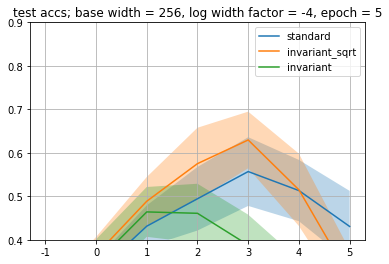

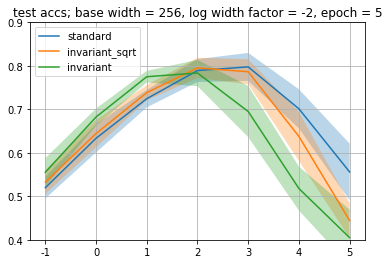

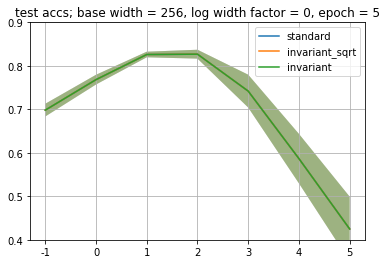

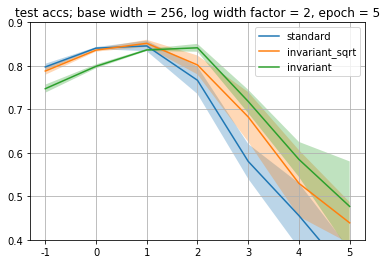

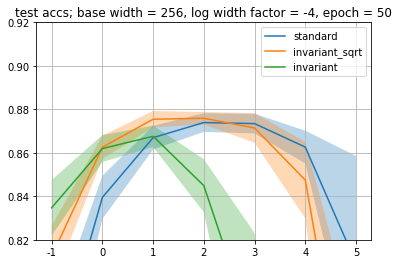

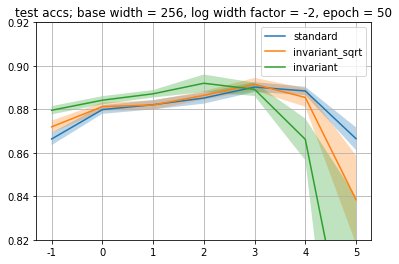

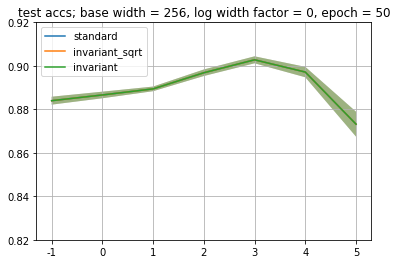

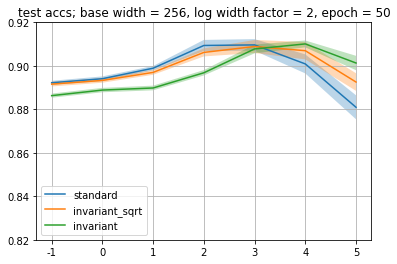

In [18]:
for base_width in base_widths[:-1]:
    for epoch in [5, 50]:
        for log_width_factor in log_width_factors:
            for scaling_mode in scaling_modes:
                data = [[
                    final_test_accs[base_width][scaling_mode][log_width_factor][log_lr_factor][seed][epoch-1]
                    for log_lr_factor in log_lr_factors
                ] for seed in range(num_seeds)]
                data = np.array(data)
                data_mean = data.mean(axis=0)
                data_std = data.std(axis=0)
                plt.plot(np.arange(len(log_lr_factors)), data_mean)
                plt.fill_between(
                    np.arange(len(log_lr_factors)),
                    data_mean - data_std,
                    data_mean + data_std,
                    alpha=0.3
                )

            plt.grid(True)
            plt.legend(scaling_modes)
            plt.xticks(np.arange(len(log_lr_factors)), log_lr_factors)
            plt.title('test accs; base width = {}, log width factor = {}, epoch = {}'.format(base_width, log_width_factor, epoch))
            if epoch == 5:
                plt.ylim((0.4,0.9))
            elif epoch == 50:
                plt.ylim((0.82,0.92))
            plt.show()

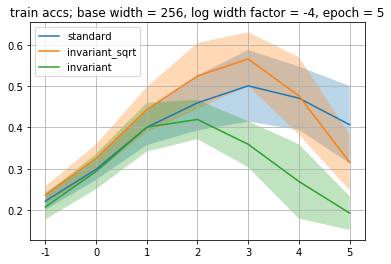

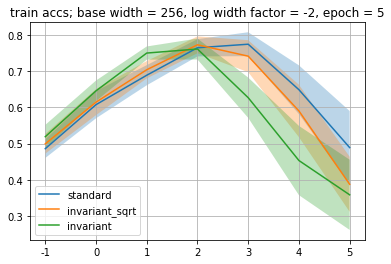

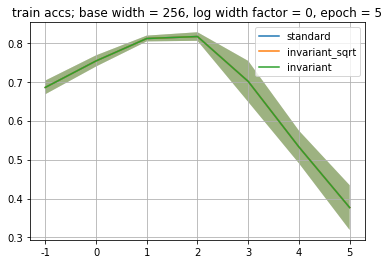

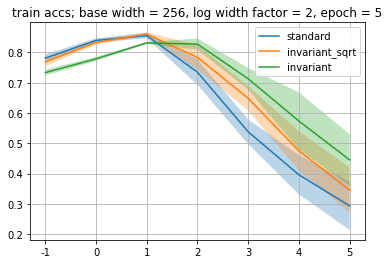

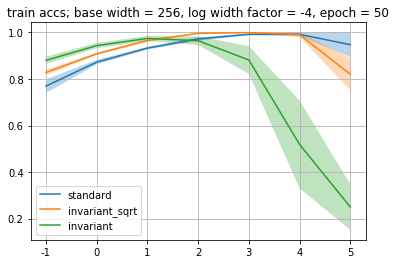

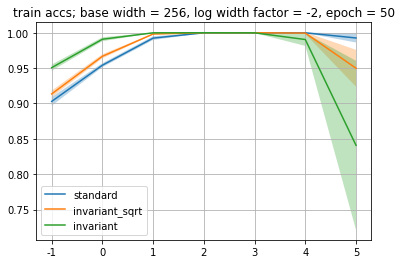

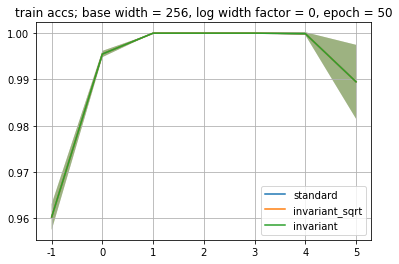

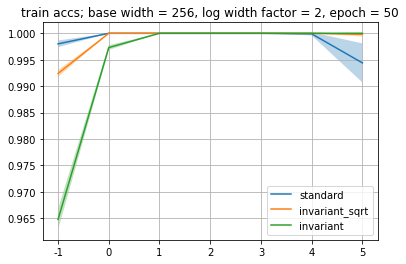

In [19]:
for base_width in base_widths[:-1]:
    for epoch in [5, 50]:
        for log_width_factor in log_width_factors:
            for scaling_mode in scaling_modes:
                data = [[
                    final_train_accs[base_width][scaling_mode][log_width_factor][log_lr_factor][seed][epoch-1]
                    for log_lr_factor in log_lr_factors
                ] for seed in range(num_seeds)]
                data = np.array(data)
                data_mean = data.mean(axis=0)
                data_std = data.std(axis=0)
                plt.plot(np.arange(len(log_lr_factors)), data_mean)
                plt.fill_between(
                    np.arange(len(log_lr_factors)),
                    data_mean - data_std,
                    data_mean + data_std,
                    alpha=0.3
                )

            plt.grid(True)
            plt.legend(scaling_modes)
            plt.xticks(np.arange(len(log_lr_factors)), log_lr_factors)
            plt.title('train accs; base width = {}, log width factor = {}, epoch = {}'.format(base_width, log_width_factor, epoch))
            #if epoch == 5:
            #    plt.ylim((0.4,0.9))
            #elif epoch == 50:
            #    plt.ylim((0.82,0.92))
            plt.show()

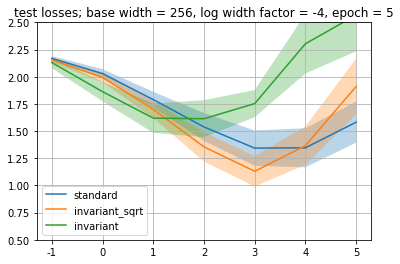

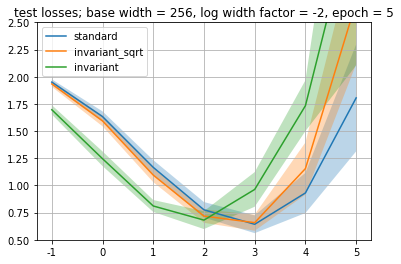

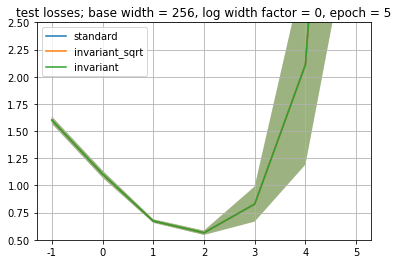

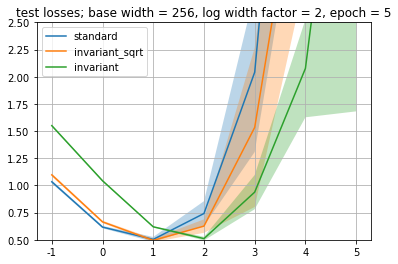

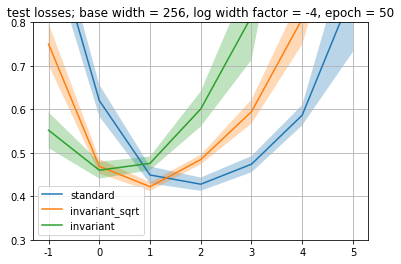

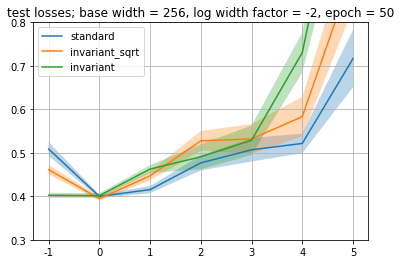

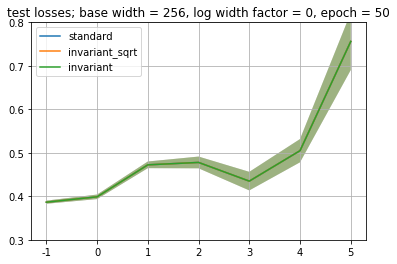

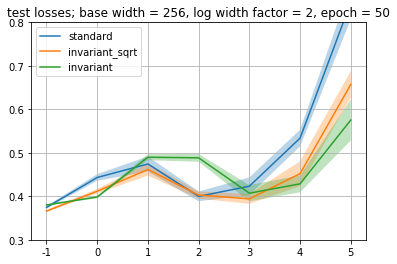

In [24]:
for base_width in base_widths[:-1]:
    for epoch in [5, 50]:
        for log_width_factor in log_width_factors:
            for scaling_mode in scaling_modes:
                data = [[
                    final_test_losses[base_width][scaling_mode][log_width_factor][log_lr_factor][seed][epoch-1]
                    for log_lr_factor in log_lr_factors
                ] for seed in range(num_seeds)]
                data = np.array(data)
                data_mean = data.mean(axis=0)
                data_std = data.std(axis=0)
                plt.plot(np.arange(len(log_lr_factors)), data_mean)
                plt.fill_between(
                    np.arange(len(log_lr_factors)),
                    data_mean - data_std,
                    data_mean + data_std,
                    alpha=0.3
                )

            plt.grid(True)
            plt.legend(scaling_modes)
            plt.xticks(np.arange(len(log_lr_factors)), log_lr_factors)
            plt.title('test losses; base width = {}, log width factor = {}, epoch = {}'.format(base_width, log_width_factor, epoch))
            if epoch == 5:
                plt.ylim((0.5,2.5))
            elif epoch == 50:
                plt.ylim((0.3,0.8))
            plt.show()

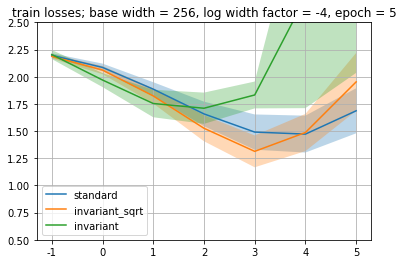

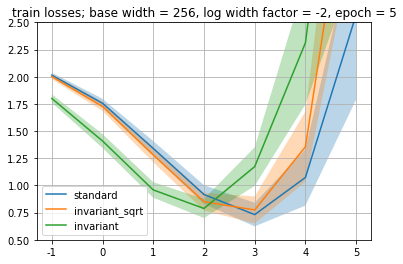

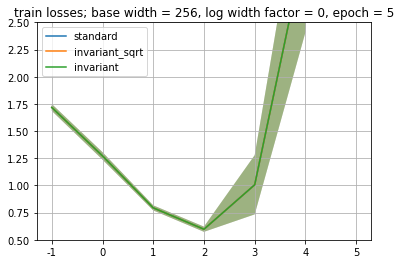

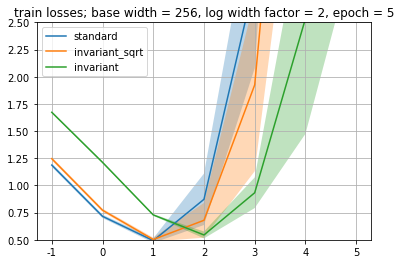

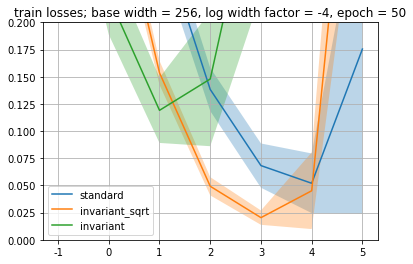

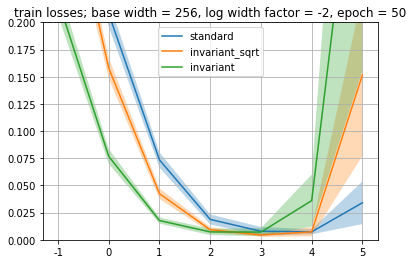

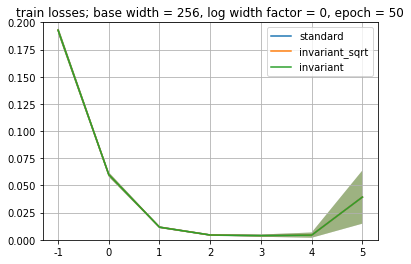

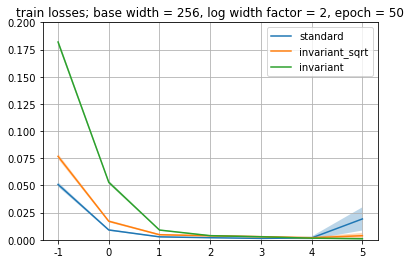

In [29]:
for base_width in base_widths[:-1]:
    for epoch in [5, 50]:
        for log_width_factor in log_width_factors:
            for scaling_mode in scaling_modes:
                data = [[
                    final_train_losses[base_width][scaling_mode][log_width_factor][log_lr_factor][seed][epoch-1]
                    for log_lr_factor in log_lr_factors
                ] for seed in range(num_seeds)]
                data = np.array(data)
                data_mean = data.mean(axis=0)
                data_std = data.std(axis=0)
                plt.plot(np.arange(len(log_lr_factors)), data_mean)
                plt.fill_between(
                    np.arange(len(log_lr_factors)),
                    data_mean - data_std,
                    data_mean + data_std,
                    alpha=0.3
                )

            plt.grid(True)
            plt.legend(scaling_modes)
            plt.xticks(np.arange(len(log_lr_factors)), log_lr_factors)
            plt.title('train losses; base width = {}, log width factor = {}, epoch = {}'.format(base_width, log_width_factor, epoch))
            if epoch == 5:
                plt.ylim((0.5,2.5))
            elif epoch == 50:
                plt.ylim((0.,0.2))
            plt.show()

## Results for base_width = 2 ** 13:

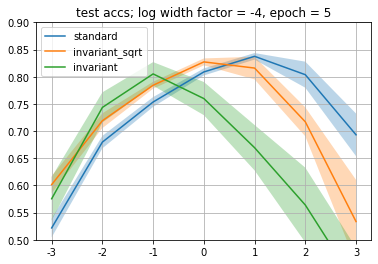

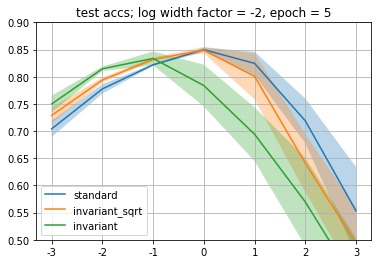

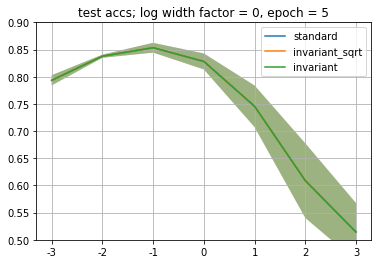

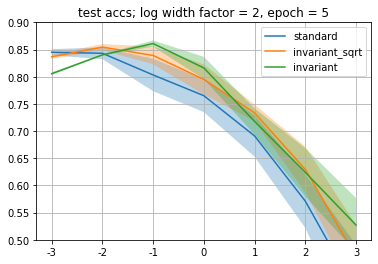

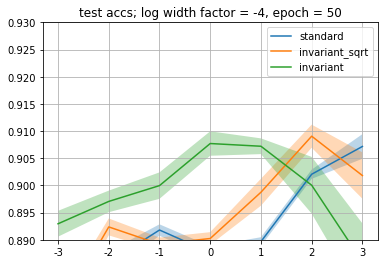

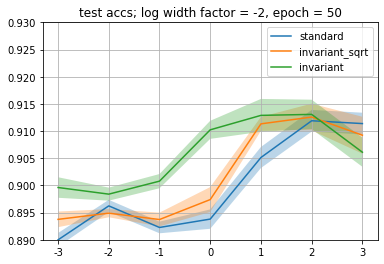

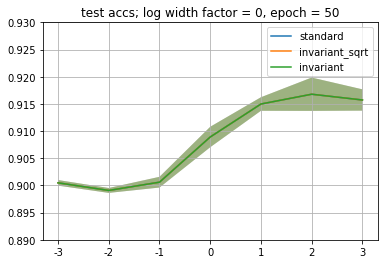

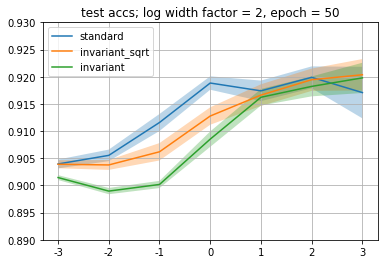

In [42]:
for num_hidden in num_hiddens:
    for epoch in [5, 50]:
        for log_width_factor in log_width_factors:
            for scaling_mode in scaling_modes:
                data = [[
                    final_test_accs[num_hidden][scaling_mode][log_width_factor][log_lr_factor][seed][epoch-1]
                    for log_lr_factor in log_lr_factors
                ] for seed in range(num_seeds)]
                data = np.array(data)
                data_mean = data.mean(axis=0)
                data_std = data.std(axis=0)
                plt.plot(np.arange(len(log_lr_factors)), data_mean)
                plt.fill_between(
                    np.arange(len(log_lr_factors)),
                    data_mean - data_std,
                    data_mean + data_std,
                    alpha=0.3
                )

            plt.grid(True)
            plt.legend(scaling_modes)
            plt.xticks(np.arange(len(log_lr_factors)), log_lr_factors)
            plt.title('test accs; log width factor = {}, epoch = {}'.format(log_width_factor, epoch))
            if epoch == 5:
                plt.ylim((0.5,0.9))
            elif epoch == 50:
                plt.ylim((0.89,0.93))
            plt.show()

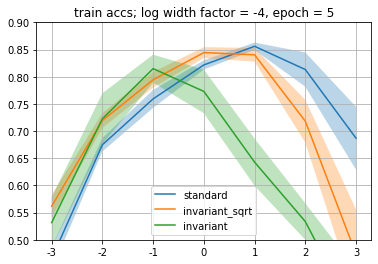

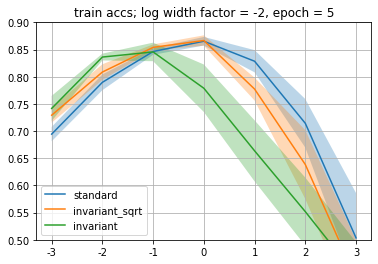

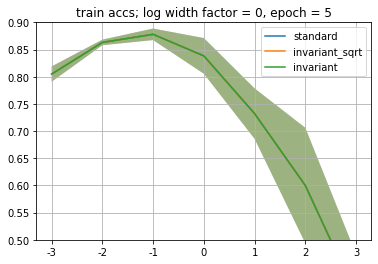

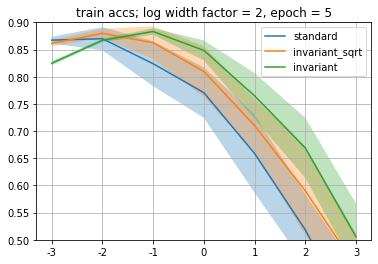

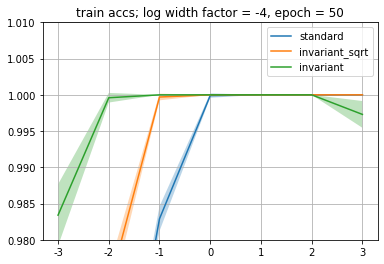

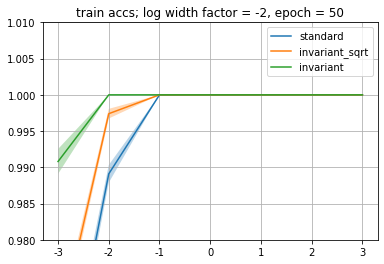

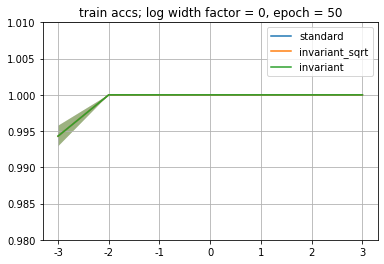

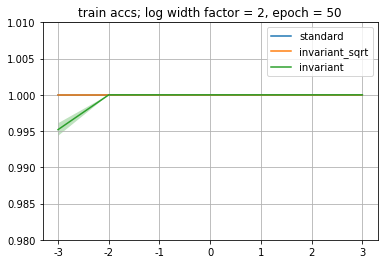

In [45]:
for num_hidden in num_hiddens:
    for epoch in [5, 50]:
        for log_width_factor in log_width_factors:
            for scaling_mode in scaling_modes:
                data = [[
                    final_train_accs[num_hidden][scaling_mode][log_width_factor][log_lr_factor][seed][epoch-1]
                    for log_lr_factor in log_lr_factors
                ] for seed in range(num_seeds)]
                data = np.array(data)
                data_mean = data.mean(axis=0)
                data_std = data.std(axis=0)
                plt.plot(np.arange(len(log_lr_factors)), data_mean)
                plt.fill_between(
                    np.arange(len(log_lr_factors)),
                    data_mean - data_std,
                    data_mean + data_std,
                    alpha=0.3
                )

            plt.grid(True)
            plt.legend(scaling_modes)
            plt.xticks(np.arange(len(log_lr_factors)), log_lr_factors)
            plt.title('train accs; log width factor = {}, epoch = {}'.format(log_width_factor, epoch))
            if epoch == 5:
                plt.ylim((0.5,0.9))
            elif epoch == 50:
                plt.ylim((0.98,1.01))
            plt.show()

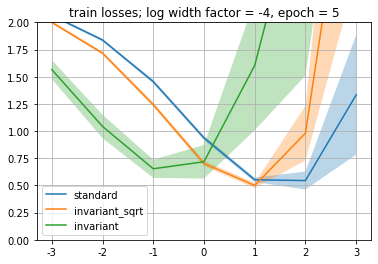

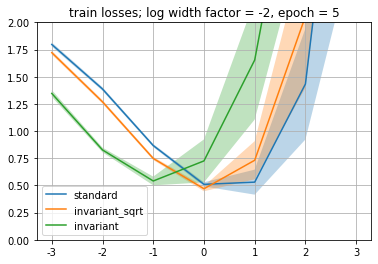

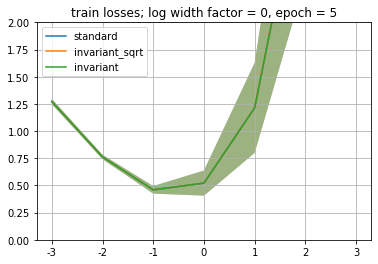

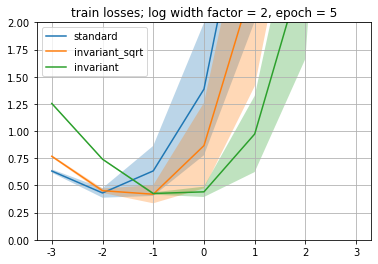

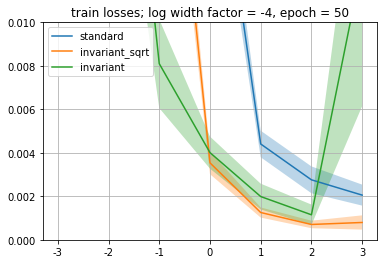

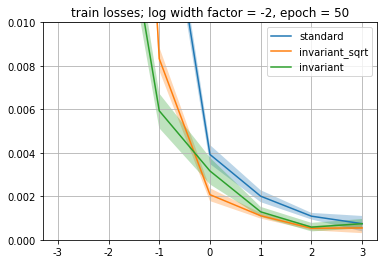

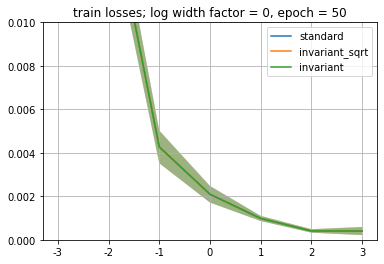

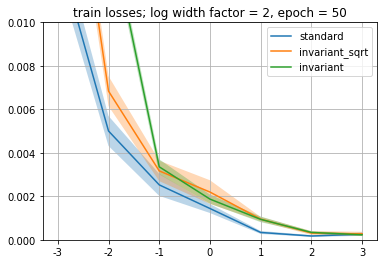

In [48]:
for num_hidden in num_hiddens:
    for epoch in [5, 50]:
        for log_width_factor in log_width_factors:
            for scaling_mode in scaling_modes:
                data = [[
                    final_train_losses[num_hidden][scaling_mode][log_width_factor][log_lr_factor][seed][epoch-1]
                    for log_lr_factor in log_lr_factors
                ] for seed in range(num_seeds)]
                data = np.array(data)
                data_mean = data.mean(axis=0)
                data_std = data.std(axis=0)
                plt.plot(np.arange(len(log_lr_factors)), data_mean)
                plt.fill_between(
                    np.arange(len(log_lr_factors)),
                    data_mean - data_std,
                    data_mean + data_std,
                    alpha=0.3
                )

            plt.grid(True)
            plt.legend(scaling_modes)
            plt.xticks(np.arange(len(log_lr_factors)), log_lr_factors)
            plt.title('train losses; log width factor = {}, epoch = {}'.format(log_width_factor, epoch))
            if epoch == 5:
                plt.ylim((0.,2.))
            elif epoch == 50:
                plt.ylim((0.,0.01))
            plt.show()

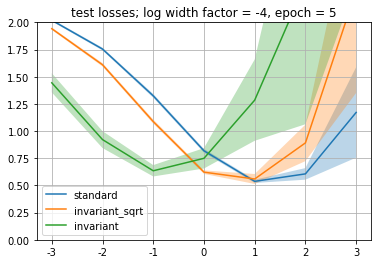

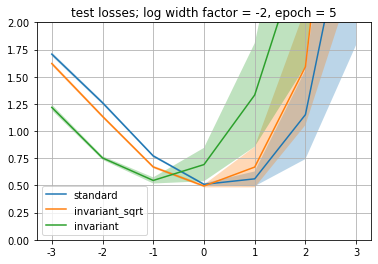

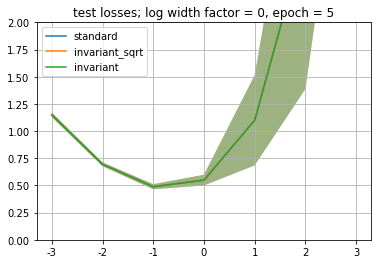

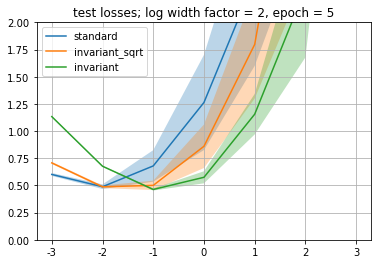

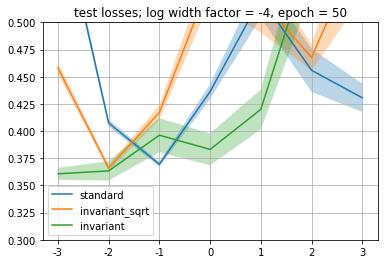

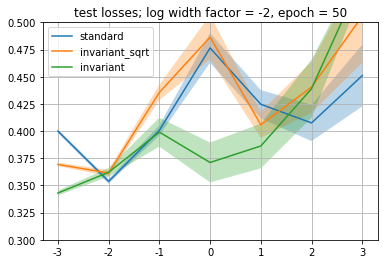

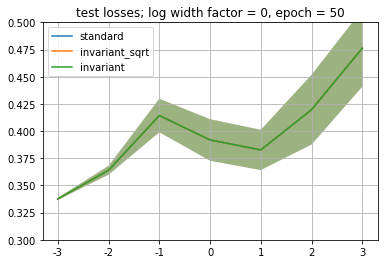

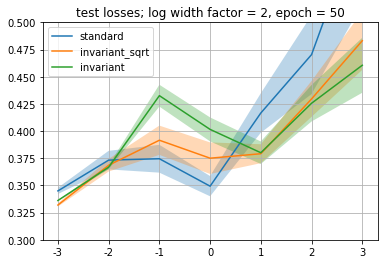

In [51]:
for num_hidden in num_hiddens:
    for epoch in [5, 50]:
        for log_width_factor in log_width_factors:
            for scaling_mode in scaling_modes:
                data = [[
                    final_test_losses[num_hidden][scaling_mode][log_width_factor][log_lr_factor][seed][epoch-1]
                    for log_lr_factor in log_lr_factors
                ] for seed in range(num_seeds)]
                data = np.array(data)
                data_mean = data.mean(axis=0)
                data_std = data.std(axis=0)
                plt.plot(np.arange(len(log_lr_factors)), data_mean)
                plt.fill_between(
                    np.arange(len(log_lr_factors)),
                    data_mean - data_std,
                    data_mean + data_std,
                    alpha=0.3
                )

            plt.grid(True)
            plt.legend(scaling_modes)
            plt.xticks(np.arange(len(log_lr_factors)), log_lr_factors)
            plt.title('test losses; log width factor = {}, epoch = {}'.format(log_width_factor, epoch))
            if epoch == 5:
                plt.ylim((0.,2.))
            elif epoch == 50:
                plt.ylim((0.3,0.5))
            plt.show()